In [1]:
# install dependencies
! pip install pandas
! pip3 install torch --index-url https://download.pytorch.org/whl/cu128
! pip install ipdb
! pip install tqdm
! pip install pyarrow
! pip install matplotlib
! pip install scikit-learn
! pip install scipy

Looking in indexes: https://download.pytorch.org/whl/cu128


In [11]:
# import libraries
import os
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import pandas as pd
import glob
import torch
from torch.utils.data import Dataset, DataLoader, random_split, IterableDataset
import gc
import pyarrow as pa
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import time
from tqdm import tqdm
import pyarrow.dataset as ds
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support
import matplotlib.pyplot as plt
import random
import json
import torch.nn.utils.prune as prune

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# ! cp drive/MyDrive/normalized-ids2018-parquet.tar.gz /content/
# ! tar -xzvf normalized-ids2018-parquet.tar.gz normalized/

In [12]:
PARQUET_FILES = glob.glob('normalized/*.parquet')
PARQUET_FILES_BENIGN = glob.glob('normalized-benign/*.parquet')
print(PARQUET_FILES)
print(PARQUET_FILES_BENIGN)

['normalized\\normalized_02-14-2018_part1.parquet', 'normalized\\normalized_02-15-2018_part1.parquet', 'normalized\\normalized_02-16-2018_part1.parquet', 'normalized\\normalized_02-20-2018_part1.parquet', 'normalized\\normalized_02-20-2018_part2.parquet', 'normalized\\normalized_02-20-2018_part3.parquet', 'normalized\\normalized_02-20-2018_part4.parquet', 'normalized\\normalized_02-20-2018_part5.parquet', 'normalized\\normalized_02-20-2018_part6.parquet', 'normalized\\normalized_02-20-2018_part7.parquet', 'normalized\\normalized_02-20-2018_part8.parquet', 'normalized\\normalized_02-21-2018_part1.parquet', 'normalized\\normalized_02-22-2018_part1.parquet', 'normalized\\normalized_02-23-2018_part1.parquet', 'normalized\\normalized_02-28-2018_part1.parquet', 'normalized\\normalized_03-01-2018_part1.parquet', 'normalized\\normalized_03-02-2018_part1.parquet']
[]


In [32]:
# canon columns

CANON_COLUMN_INDEX = ['Fwd IAT Tot', 'Fwd Pkt Len Min', 'Down/Up Ratio', 'Dst Port', 'Fwd IAT Std', 'Fwd Header Len', 'Fwd IAT Min', 'Flow IAT Std', 'Active Std', 'Bwd IAT Max', 'Fwd Pkt Len Mean', 'Flow IAT Mean', 'Fwd Act Data Pkts', 'Bwd Pkt Len Max', 'Flow IAT Max', 'ACK Flag Cnt', 'Bwd IAT Tot', 'Flow IAT Min', 'Bwd Pkts/b Avg', 'Fwd IAT Max', 'SYN Flag Cnt', 'Bwd Header Len', 'Fwd Seg Size Avg', 'Bwd Byts/b Avg', 'Subflow Bwd Byts', 'Bwd Pkts/s', 'Fwd IAT Mean', 'Fwd Pkt Len Std', 'Init Bwd Win Byts', 'Active Min', 'Subflow Fwd Byts', 'Init Fwd Win Byts', 'Bwd Pkt Len Std', 'Fwd PSH Flags', 'Fwd Pkts/s', 'Bwd Blk Rate Avg', 'Flow Byts/s', 'CWE Flag Count', 'Active Max', 'Fwd Byts/b Avg', 'Fwd Blk Rate Avg', 'Fwd Pkts/b Avg', 'Idle Mean', 'Idle Std', 'Fwd Pkt Len Max', 'Flow Duration', 'Fwd Seg Size Min', 'Bwd IAT Min', 'TotLen Fwd Pkts', 'Flow Pkts/s', 'Active Mean', 'ECE Flag Cnt', 'Idle Min', 'Subflow Bwd Pkts', 'Bwd Pkt Len Mean', 'Tot Fwd Pkts', 'Bwd IAT Std', 'Bwd Seg Size Avg', 'Bwd URG Flags', 'Bwd Pkt Len Min', 'Tot Bwd Pkts', 'Subflow Fwd Pkts', 'Bwd IAT Mean', 'FIN Flag Cnt', 'Bwd PSH Flags', 'TotLen Bwd Pkts', 'Fwd URG Flags', 'Idle Max']
CANON_COLUMN_INDEX.sort()
CANON_COLUMN_INDEX.append('Label')
index_map = {'ack_flag_cnt': 'ACK Flag Cnt', 'active_max': 'Active Max', 'active_mean': 'Active Mean', 'active_min': 'Active Min', 'active_std': 'Active Std', 'bwd_blk_rate_avg': 'Bwd Blk Rate Avg', 'bwd_byts_b_avg': 'Bwd Byts/b Avg', 'bwd_header_len': 'Bwd Header Len', 'bwd_iat_max': 'Bwd IAT Max', 'bwd_iat_mean': 'Bwd IAT Mean', 'bwd_iat_min': 'Bwd IAT Min', 'bwd_iat_std': 'Bwd IAT Std', 'bwd_iat_tot': 'Bwd IAT Tot', 'bwd_psh_flags': 'Bwd PSH Flags', 'bwd_pkt_len_max': 'Bwd Pkt Len Max', 'bwd_pkt_len_mean': 'Bwd Pkt Len Mean', 'bwd_pkt_len_min': 'Bwd Pkt Len Min', 'bwd_pkt_len_std': 'Bwd Pkt Len Std', 'bwd_pkts_b_avg': 'Bwd Pkts/b Avg', 'bwd_pkts_s': 'Bwd Pkts/s', 'bwd_seg_size_avg': 'Bwd Seg Size Avg', 'bwd_urg_flags': 'Bwd URG Flags', 'cwr_flag_count': 'CWE Flag Count', 'down_up_ratio': 'Down/Up Ratio', 'dst_port': 'Dst Port', 'ece_flag_cnt': 'ECE Flag Cnt', 'fin_flag_cnt': 'FIN Flag Cnt', 'flow_byts_s': 'Flow Byts/s', 'flow_duration': 'Flow Duration', 'flow_iat_max': 'Flow IAT Max', 'flow_iat_mean': 'Flow IAT Mean', 'flow_iat_min': 'Flow IAT Min', 'flow_iat_std': 'Flow IAT Std', 'flow_pkts_s': 'Flow Pkts/s', 'fwd_act_data_pkts': 'Fwd Act Data Pkts', 'fwd_blk_rate_avg': 'Fwd Blk Rate Avg', 'fwd_byts_b_avg': 'Fwd Byts/b Avg', 'fwd_header_len': 'Fwd Header Len', 'fwd_iat_max': 'Fwd IAT Max', 'fwd_iat_mean': 'Fwd IAT Mean', 'fwd_iat_min': 'Fwd IAT Min', 'fwd_iat_std': 'Fwd IAT Std', 'fwd_iat_tot': 'Fwd IAT Tot', 'fwd_psh_flags': 'Fwd PSH Flags', 'fwd_pkt_len_max': 'Fwd Pkt Len Max', 'fwd_pkt_len_mean': 'Fwd Pkt Len Mean', 'fwd_pkt_len_min': 'Fwd Pkt Len Min', 'fwd_pkt_len_std': 'Fwd Pkt Len Std', 'fwd_pkts_b_avg': 'Fwd Pkts/b Avg', 'fwd_pkts_s': 'Fwd Pkts/s', 'fwd_seg_size_avg': 'Fwd Seg Size Avg', 'fwd_seg_size_min': 'Fwd Seg Size Min', 'fwd_urg_flags': 'Fwd URG Flags', 'idle_max': 'Idle Max', 'idle_mean': 'Idle Mean', 'idle_min': 'Idle Min', 'idle_std': 'Idle Std', 'init_bwd_win_byts': 'Init Bwd Win Byts', 'init_fwd_w': 'Init Fwd Win Byts', 'syn_flag_cnt': 'SYN Flag Cnt', 'subflow_bwd_pkts': 'Subflow Bwd Byts', 'subflow_fwd_byts': 'Subflow Bwd Pkts', 'subflow_fwd_pkts': 'Subflow Fwd Byts', 'tot_bwd_pkts': 'Subflow Fwd Pkts', 'tot_fwd_pkts': 'Tot Bwd Pkts', 'totlen_bwd_pkts': 'Tot Fwd Pkts', 'totlen_fwd_pkts': 'TotLen Bwd Pkts', 'urg_flag_cnt': 'TotLen Fwd Pkts'}

TRAINING_UNWANTED_COLUMNS = ['Timestamp', 'Flow ID', 'Dst IP', "Src IP"]
TRAINING_WANTED_COLUMNS = []
for col in CANON_COLUMN_INDEX:
  if col not in TRAINING_UNWANTED_COLUMNS:
    TRAINING_WANTED_COLUMNS.append(col)
  if col not in index_map.values():
    print(col)
print(TRAINING_WANTED_COLUMNS)
TRAINING_FEATURES = TRAINING_WANTED_COLUMNS[:-1]

CANON_SCHEMA = pa.schema([(feature, pa.float32()) for feature in TRAINING_FEATURES])

Label
['ACK Flag Cnt', 'Active Max', 'Active Mean', 'Active Min', 'Active Std', 'Bwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Header Len', 'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Tot', 'Bwd PSH Flags', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Bwd Pkts/b Avg', 'Bwd Pkts/s', 'Bwd Seg Size Avg', 'Bwd URG Flags', 'CWE Flag Count', 'Down/Up Ratio', 'Dst Port', 'ECE Flag Cnt', 'FIN Flag Cnt', 'Flow Byts/s', 'Flow Duration', 'Flow IAT Max', 'Flow IAT Mean', 'Flow IAT Min', 'Flow IAT Std', 'Flow Pkts/s', 'Fwd Act Data Pkts', 'Fwd Blk Rate Avg', 'Fwd Byts/b Avg', 'Fwd Header Len', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Min', 'Fwd IAT Std', 'Fwd IAT Tot', 'Fwd PSH Flags', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Fwd Pkts/b Avg', 'Fwd Pkts/s', 'Fwd Seg Size Avg', 'Fwd Seg Size Min', 'Fwd URG Flags', 'Idle Max', 'Idle Mean', 'Idle Min', 'Idle Std', 'Init Bwd Win Byts', 'Init Fwd Win Byts', 'SYN Fl

In [34]:
# pyarrow parquet dataset
class ArrowParquetDataset(IterableDataset):
    def __init__(self, path, batch_size=1024, shuffle=True, splits=[0.7,0.1,0.2]):
        self.path = path
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.splits = splits
        self.mode("train")

        self.dataset = ds.dataset(self.path, format="parquet")
        self.scanner = self.dataset.scanner(columns=TRAINING_WANTED_COLUMNS, batch_size=self.batch_size)

    def mode(self, m):
        self.mode_value = m

    # approximate iterations
    def num_iterations(self):
        return int((len(self) * self.splits[self.mode_value]) / self.batch_size)

    def __len__(self):
        return self.scanner.count_rows()

    def __iter__(self):
        batches = list(self.scanner.to_batches())

        num_batches = len(batches)
        batch_intervals = [0]
        running_total = 0
        for i in range(len(self.splits) - 1):
            length = int(np.floor(num_batches * self.splits[i]))
            batch_intervals.append(length + running_total)
            running_total += length
        batch_intervals.append(num_batches)

        batches = batches[batch_intervals[self.mode_value]:batch_intervals[self.mode_value + 1]]

        if self.shuffle:
            random.shuffle(batches)

        for batch in batches:
            x = batch.select(TRAINING_FEATURES).to_tensor(null_to_nan=True)
            
            y_string_array = batch.column("Label")
            y = torch.tensor([(0.0 if val.as_py() == "Benign" else 1.0) for val in y_string_array], dtype=torch.float16)
            x = torch.tensor(x, dtype=torch.float16)

            # in val and train modes ignore intrusions
            if (self.mode_value == 0 or self.mode_value == 1):
                benign_mask = (y == 0.0)
                x = x[benign_mask]
                y = y[benign_mask]
            
            # mask and impute nans
            mask = torch.isnan(x).float()
            x = torch.nan_to_num(x, nan=0.0)
            x = torch.cat([x, mask], dim=1)
            
            yield x, y

DS_ARROW = ArrowParquetDataset(PARQUET_FILES, batch_size=512, splits=[0.6,0.1,0.1,0.2])
print(len(DS_ARROW))

16233002


In [35]:
# dnn model
class DNN(nn.Module):
  def __init__(self, input_size, hidden_sizes, output_size):
    super(DNN, self).__init__()

    #layers
    self.input = nn.Linear(input_size, hidden_sizes[0])
    self.output = nn.Linear(hidden_sizes[-1], output_size)
    self.dropout = nn.Dropout(0.6)
    self.hiddens = nn.ModuleList()
    for i in range(len(hidden_sizes) - 1):
      self.hiddens.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))

  def forward(self, x):
    x = F.relu(self.input(x))
    for layer in self.hiddens:
      x = F.relu(layer(x))
    x = self.dropout(x)
    x = self.output(x)
    # return torch.sigmoid(x).view(-1)
    return x

In [44]:
# create model
input_shape = len(TRAINING_FEATURES) * 2 # because masking

# autoencoder
model = DNN(
    input_shape,
    [int(input_shape / 2), int(int(input_shape / 4))],
    input_shape
)

model_desc = model.__str__()
print(model_desc)

DNN(
  (input): Linear(in_features=136, out_features=68, bias=True)
  (output): Linear(in_features=34, out_features=136, bias=True)
  (dropout): Dropout(p=0.6, inplace=False)
  (hiddens): ModuleList(
    (0): Linear(in_features=68, out_features=34, bias=True)
  )
)


In [45]:
# train
torch.cuda.empty_cache()

model.to(device)
loss_fn = nn.MSELoss()
loss_fn_no_reduction = nn.MSELoss(reduction='none')
lr = 0.00001
beta1 = 0.9
beta2 = 0.999
weight_decay = 0.001
optim = torch.optim.Adam(model.parameters(), lr=lr, betas=(beta1,beta2), weight_decay=weight_decay)
epochs = 20
train_loss = -1

reconstruction_l2 = 0.0

historical_loss = []
historical_val_loss = []
historical_reconstruction = []

train_start_time = time.time()
for epoch in range(epochs):
  epoch_loss = 0.0
  epoch_val_loss = 0.0

  model.train()
  epoch_samples = 0
  DS_ARROW.mode(0)
  for x, _ in tqdm(DS_ARROW, total=DS_ARROW.num_iterations()):
    x = x.to(device)
    batch_size = x.size()[0]
    if batch_size == 0: continue
    epoch_samples += batch_size

    optim.zero_grad()
    out = model(x)
    loss = loss_fn(out, x)
    loss.backward()
    optim.step()
    epoch_loss += loss.item() * batch_size

  epoch_loss = epoch_loss / epoch_samples

  epoch_l2s = []

  model.eval()
  epoch_val_samples = 0
  DS_ARROW.mode(1)
  with torch.no_grad():
    for x, _ in tqdm(DS_ARROW, total=DS_ARROW.num_iterations()):
      x = x.to(device)
      batch_size = x.size()[0]
      if batch_size == 0: continue
      epoch_val_samples += batch_size

      out = model(x)
      loss = loss_fn(out, x)
      epoch_val_loss += loss.item() * batch_size

  epoch_val_loss = epoch_val_loss / epoch_val_samples
  historical_val_loss.append(epoch_val_loss)
  historical_loss.append(epoch_loss)

  print(f'epoch: {epoch + 1}/{epochs}, train loss: {epoch_loss:.5f}, val loss: {epoch_val_loss:.5f}')
  train_loss = epoch_loss
min, sec = divmod(int(time.time() - train_start_time), 60)
print(f'train time: {min}:{sec}')

19025it [01:06, 285.44it/s]                           
100%|██████████| 3170/3170 [00:09<00:00, 337.34it/s]


epoch: 1/20, train loss: 0.36501, val loss: 0.12715


19025it [01:05, 289.11it/s]                           
100%|██████████| 3170/3170 [00:09<00:00, 323.51it/s]


epoch: 2/20, train loss: 0.28062, val loss: 0.09969


19025it [01:03, 299.94it/s]                           
100%|██████████| 3170/3170 [00:09<00:00, 338.77it/s]


epoch: 3/20, train loss: 0.24105, val loss: 0.08446


19025it [01:05, 289.79it/s]                           
100%|██████████| 3170/3170 [00:09<00:00, 331.25it/s]


epoch: 4/20, train loss: 0.22172, val loss: 0.07777


19025it [01:04, 292.87it/s]                           
100%|██████████| 3170/3170 [00:09<00:00, 341.85it/s]


epoch: 5/20, train loss: 0.21060, val loss: 0.07275


19025it [01:04, 293.80it/s]                           
100%|██████████| 3170/3170 [00:10<00:00, 313.85it/s]


epoch: 6/20, train loss: 0.20301, val loss: 0.07012


19025it [01:07, 280.31it/s]                           
100%|██████████| 3170/3170 [00:11<00:00, 278.40it/s]


epoch: 7/20, train loss: 0.19836, val loss: 0.06857


19025it [01:07, 283.23it/s]                           
100%|██████████| 3170/3170 [00:10<00:00, 313.21it/s]


epoch: 8/20, train loss: 0.19509, val loss: 0.06750


19025it [01:05, 288.64it/s]                           
100%|██████████| 3170/3170 [00:09<00:00, 341.61it/s]


epoch: 9/20, train loss: 0.19306, val loss: 0.06717


19025it [01:03, 298.28it/s]                           
100%|██████████| 3170/3170 [00:09<00:00, 336.76it/s]


epoch: 10/20, train loss: 0.19184, val loss: 0.06678


19025it [01:03, 301.91it/s]                           
100%|██████████| 3170/3170 [00:09<00:00, 344.57it/s]


epoch: 11/20, train loss: 0.19124, val loss: 0.06643


19025it [01:03, 300.87it/s]                           
100%|██████████| 3170/3170 [00:10<00:00, 297.14it/s]


epoch: 12/20, train loss: 0.19003, val loss: 0.06635


19025it [01:02, 303.50it/s]                           
100%|██████████| 3170/3170 [00:09<00:00, 318.95it/s]


epoch: 13/20, train loss: 0.18926, val loss: 0.06602


19025it [01:06, 288.19it/s]                           
100%|██████████| 3170/3170 [00:10<00:00, 288.20it/s]


epoch: 14/20, train loss: 0.18867, val loss: 0.06567


19025it [01:05, 289.93it/s]                           
100%|██████████| 3170/3170 [00:09<00:00, 321.12it/s]


epoch: 15/20, train loss: 0.18876, val loss: 0.06535


19025it [01:06, 287.94it/s]                           
100%|██████████| 3170/3170 [00:09<00:00, 320.75it/s]


epoch: 16/20, train loss: 0.18763, val loss: 0.06511


19025it [01:06, 285.25it/s]                           
100%|██████████| 3170/3170 [00:09<00:00, 322.14it/s]


epoch: 17/20, train loss: 0.18757, val loss: 0.06507


19025it [01:07, 283.56it/s]                           
100%|██████████| 3170/3170 [00:09<00:00, 320.31it/s]


epoch: 18/20, train loss: 0.18774, val loss: 0.06487


19025it [01:06, 287.83it/s]                           
  0%|          | 0/3170 [00:00<?, ?it/s]

: 

In [ ]:
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Linear):
        print(f"{name}: original weight: {torch.sum(module.weight == 0).item()}")
        module = prune.l1_unstructured(module, name='weight', amount=0.2)
        prune.remove(module, 'weight')

for name, module in model.named_modules():
    if isinstance(module, torch.nn.Linear):
        print(f"{name}: Pruned weights: {torch.sum(module.weight == 0).item()} zeros")

In [38]:
# threshold search
search_start = 10
search_depth = 4
search_length = search_depth * 20
search_counter = 0

best_fscore = np.array([-1,-1])
best_fscore_sum = -1
best_threshold = -1
best_percision = -1
best_recall = -1

historical_threshold = []
historical_fscore = []

threshold_search_start_time = time.time()
for i in range(search_depth):
    search_step = 10 ** (i * -1)
    for j in range(-9,10):
        search_counter += 1
        threshold = j * search_step + search_start
        y_pred_tensor = []
        y_true_tensor = []

        DS_ARROW.mode(2)
        test_loss = 0.0
        with torch.no_grad():
            for x, y in tqdm(DS_ARROW, total=DS_ARROW.num_iterations()):
                x = x.to(device)
                y = y.to(device)

                out = model(x)
                reconstruction_losses = loss_fn_no_reduction(out, x)
                l2_dists = torch.norm(reconstruction_losses, p=2, dim=1)
                thresholded = (l2_dists > threshold).float()
                y_pred_tensor.append(thresholded.bool())
                y_true_tensor.append(y.bool())
        
        y_pred = torch.cat(y_pred_tensor).tolist()
        y_true = torch.cat(y_true_tensor).tolist()

        percision, recall, fscore, support = precision_recall_fscore_support(y_true, y_pred)
        curr_weighted_sum = fscore[0] + 1 * fscore[1]
        historical_fscore.append(curr_weighted_sum)
        historical_threshold.append(threshold)
        print(f"search: {search_counter}/{search_length}, threshold: {threshold}, percision: {percision}, recall: {recall}, fscore: {fscore}, fscore weighted sum: {curr_weighted_sum}")
        if best_fscore_sum < curr_weighted_sum:
            best_threshold = threshold
            best_fscore_sum = curr_weighted_sum
            best_fscore = fscore
            best_percision = percision
            best_recall = recall
    
    search_start = best_threshold

print(f"best threshold: {best_threshold}, percision: {best_percision}, recall: {best_recall}, fscore: {best_fscore}, fscore weighted sum: {best_fscore_sum}")
min, sec = divmod(int(time.time() - threshold_search_start_time), 60)
print(f'train time: {min}:{sec}')


100%|██████████| 3170/3170 [00:09<00:00, 319.52it/s]


search: 1/80, threshold: 1, percision: [0.99999131 0.30338551], recall: [0.19179582 0.99999527], fscore: [0.32185974 0.46553406], fscore weighted sum: 0.7873938050256828


100%|██████████| 3170/3170 [00:10<00:00, 296.93it/s]


search: 2/80, threshold: 2, percision: [0.99969709 0.35778203], recall: [0.36838611 0.99968288], fscore: [0.5383803  0.52696547], fscore weighted sum: 1.0653457712458527


100%|██████████| 3170/3170 [00:09<00:00, 325.68it/s]


search: 3/80, threshold: 3, percision: [0.76157407 0.277863  ], recall: [0.45730351 0.59325672], fscore: [0.57146099 0.37846484], fscore weighted sum: 0.9499258305427393


100%|██████████| 3170/3170 [00:10<00:00, 291.62it/s]


search: 4/80, threshold: 4, percision: [0.60972024 0.0518149 ], recall: [0.50788223 0.07640207], fscore: [0.5541614  0.06175104], fscore weighted sum: 0.61591244362697


100%|██████████| 3170/3170 [00:09<00:00, 321.98it/s]


search: 5/80, threshold: 5, percision: [0.62465224 0.05489647], recall: [0.54144783 0.0756708 ], fscore: [0.5800816  0.06363095], fscore weighted sum: 0.6437125584898628


100%|██████████| 3170/3170 [00:10<00:00, 312.39it/s]


search: 6/80, threshold: 6, percision: [0.63397924 0.05749661], recall: [0.56355306 0.0756424 ], fscore: [0.59669529 0.06533294], fscore weighted sum: 0.6620282364504402


100%|██████████| 3170/3170 [00:10<00:00, 308.77it/s]


search: 7/80, threshold: 7, percision: [0.64003174 0.05940962], recall: [0.57850369 0.0756353 ], fscore: [0.60771433 0.0665477 ], fscore weighted sum: 0.6742620348015846


100%|██████████| 3170/3170 [00:09<00:00, 333.30it/s]


search: 8/80, threshold: 8, percision: [0.64422841 0.06085286], recall: [0.58917021 0.0756282 ], fscore: [0.61547043 0.06744075], fscore weighted sum: 0.6829111750256465


100%|██████████| 3170/3170 [00:09<00:00, 327.69it/s]


search: 9/80, threshold: 9, percision: [0.64718528 0.06193647], recall: [0.59683628 0.07562584], fscore: [0.6209919  0.06810001], fscore weighted sum: 0.6890919126959428


100%|██████████| 3170/3170 [00:09<00:00, 317.89it/s]


search: 10/80, threshold: 10, percision: [0.64924953 0.0627125 ], recall: [0.60227908 0.07560217], fscore: [0.62488289 0.06855674], fscore weighted sum: 0.6934396303845001


100%|██████████| 3170/3170 [00:09<00:00, 333.15it/s]


search: 11/80, threshold: 11, percision: [0.65180479 0.06096519], recall: [0.6117111  0.07161925], fscore: [0.63112182 0.06586416], fscore weighted sum: 0.6969859798106562


100%|██████████| 3170/3170 [00:09<00:00, 330.16it/s]


search: 12/80, threshold: 12, percision: [0.6592673  0.04324529], recall: [0.65047293 0.0448842 ], fscore: [0.65484059 0.04404951], fscore weighted sum: 0.6988900999499904


100%|██████████| 3170/3170 [00:09<00:00, 324.18it/s]


search: 13/80, threshold: 13, percision: [0.67759327 0.01463614], recall: [0.73137357 0.01133583], fscore: [0.70345702 0.0127763 ], fscore weighted sum: 0.7162333202028727


100%|██████████| 3170/3170 [00:10<00:00, 309.19it/s]


search: 14/80, threshold: 14, percision: [0.700453   0.00130785], recall: [8.22531727e-01 6.60270640e-04], fscore: [0.7565996  0.00087752], fscore weighted sum: 0.7574771203360202


100%|██████████| 3170/3170 [00:09<00:00, 331.02it/s]


search: 15/80, threshold: 15, percision: [0.7195885  0.00075572], recall: [9.03074174e-01 2.08257406e-04], fscore: [8.00957342e-01 3.26530612e-04], fscore weighted sum: 0.8012838728092558


100%|██████████| 3170/3170 [00:10<00:00, 312.60it/s]


search: 16/80, threshold: 16, percision: [0.73013247 0.00135546], recall: [9.52130181e-01 1.84591792e-04], fscore: [8.26483498e-01 3.24932983e-04], fscore weighted sum: 0.8268084312303898


100%|██████████| 3170/3170 [00:09<00:00, 329.03it/s]


search: 17/80, threshold: 17, percision: [0.73450036 0.00260932], recall: [9.73572348e-01 1.96424599e-04], fscore: [8.37305384e-01 3.65346650e-04], fscore weighted sum: 0.8376707306166319


100%|██████████| 3170/3170 [00:09<00:00, 344.04it/s]


search: 18/80, threshold: 18, percision: [0.73585994 0.00284404], recall: [9.80432075e-01 1.58559616e-04], fscore: [8.40720209e-01 3.00373001e-04], fscore weighted sum: 0.841020581745894


100%|██████████| 3170/3170 [00:09<00:00, 317.90it/s]


search: 19/80, threshold: 19, percision: [0.73625461 0.00307227], recall: [9.82430434e-01 1.53826493e-04], fscore: [8.41712024e-01 2.92983496e-04], fscore weighted sum: 0.842005007652736


100%|██████████| 3170/3170 [00:09<00:00, 326.46it/s]


search: 20/80, threshold: 1.1, percision: [0.99998419 0.30840815], recall: [0.21069401 0.99999053], fscore: [0.34805397 0.47142393], fscore weighted sum: 0.8194779080672858


100%|██████████| 3170/3170 [00:09<00:00, 331.75it/s]


search: 21/80, threshold: 1.2, percision: [0.99996014 0.31367957], recall: [0.22988625 0.99997397], fscore: [0.37383057 0.47755575], fscore weighted sum: 0.8513863241144928


100%|██████████| 3170/3170 [00:09<00:00, 320.98it/s]


search: 22/80, threshold: 1.2999999999999998, percision: [0.99987663 0.31933071], recall: [0.24978988 0.99991244], fscore: [0.39972114 0.4840696 ], fscore weighted sum: 0.883790734879479


100%|██████████| 3170/3170 [00:09<00:00, 319.93it/s]


search: 23/80, threshold: 1.4, percision: [0.99985539 0.32549889], recall: [0.27069309 0.99988877], fscore: [0.42604269 0.49112074], fscore weighted sum: 0.9171634365520993


100%|██████████| 3170/3170 [00:09<00:00, 327.27it/s]


search: 24/80, threshold: 1.5, percision: [0.99983127 0.33179489], recall: [0.29123063 0.99986037], fscore: [0.45107286 0.49824991], fscore weighted sum: 0.9493227689323986


100%|██████████| 3170/3170 [00:09<00:00, 342.90it/s]


search: 25/80, threshold: 1.6, percision: [0.99976363 0.33777392], recall: [0.31005385 0.99979174], fscore: [0.47331872 0.50495252], fscore weighted sum: 0.9782712367887758


100%|██████████| 3170/3170 [00:09<00:00, 319.41it/s]


search: 26/80, threshold: 1.7, percision: [0.99975013 0.34322576], recall: [0.32661882 0.99976808], fscore: [0.49237765 0.51101673], fscore weighted sum: 1.0033943796437013


100%|██████████| 3170/3170 [00:09<00:00, 340.48it/s]


search: 27/80, threshold: 1.8, percision: [0.99972994 0.34854487], recall: [0.34228583 0.99973731], fscore: [0.50996925 0.51688484], fscore weighted sum: 1.02685409015877


100%|██████████| 3170/3170 [00:09<00:00, 345.53it/s]


search: 28/80, threshold: 1.9, percision: [0.99969629 0.35349437], recall: [0.35645093 0.99969235], fscore: [0.52552211 0.52230133], fscore weighted sum: 1.0478234459710913


100%|██████████| 3170/3170 [00:08<00:00, 358.70it/s]


search: 29/80, threshold: 2.0, percision: [0.99970418 0.35792341], recall: [0.36877012 0.99968998], fscore: [0.53879131 0.5271198 ], fscore weighted sum: 1.0659111097715745


100%|██████████| 3170/3170 [00:09<00:00, 330.65it/s]


search: 30/80, threshold: 2.1, percision: [0.99969565 0.3621742 ], recall: [0.38032045 0.99967105], fscore: [0.55101488 0.53171249], fscore weighted sum: 1.0827273689793224


100%|██████████| 3170/3170 [00:10<00:00, 305.95it/s]


search: 31/80, threshold: 2.2, percision: [0.99967684 0.36645209], recall: [0.39168086 0.99964028], fscore: [0.5628377  0.53630381], fscore weighted sum: 1.0991415162196476


100%|██████████| 3170/3170 [00:10<00:00, 295.87it/s]


search: 32/80, threshold: 2.3, percision: [0.99923269 0.37006676], recall: [0.40136861 0.99912437], fscore: [0.5726978  0.54008927], fscore weighted sum: 1.1127870639320512


100%|██████████| 3170/3170 [00:10<00:00, 294.24it/s]


search: 33/80, threshold: 2.4, percision: [0.99545518 0.37269164], recall: [0.41069901 0.99467287], fscore: [0.58149022 0.54222011], fscore weighted sum: 1.1237103286721812


100%|██████████| 3170/3170 [00:10<00:00, 304.98it/s]


search: 34/80, threshold: 2.5, percision: [0.98194465 0.37235011], recall: [0.41968454 0.97807617], fscore: [0.58803997 0.53936564], fscore weighted sum: 1.1274056074290932


100%|██████████| 3170/3170 [00:10<00:00, 313.10it/s]


search: 35/80, threshold: 2.6, percision: [0.9543581  0.36690741], recall: [0.42797036 0.94185122], fscore: [0.59094056 0.52809156], fscore weighted sum: 1.1190321220363955


100%|██████████| 3170/3170 [00:10<00:00, 290.41it/s]


search: 36/80, threshold: 2.7, percision: [0.91323414 0.35508209], recall: [0.43592965 0.8823322 ], fscore: [0.59015197 0.50637909], fscore weighted sum: 1.0965310654704141


100%|██████████| 3170/3170 [00:10<00:00, 314.58it/s]


search: 37/80, threshold: 2.8, percision: [0.86395627 0.33637311], recall: [0.44328167 0.80169162], fscore: [0.58593156 0.47390539], fscore weighted sum: 1.0598369478366


100%|██████████| 3170/3170 [00:10<00:00, 288.96it/s]


search: 38/80, threshold: 2.9, percision: [0.81265892 0.3110783 ], recall: [0.45045627 0.70497972], fscore: [0.57962617 0.43167592], fscore weighted sum: 1.0113020897283687


100%|██████████| 3170/3170 [00:09<00:00, 328.97it/s]


search: 39/80, threshold: 2.41, percision: [0.99486279 0.37297716], recall: [0.41184105 0.99395817], fscore: [0.58253247 0.54241585], fscore weighted sum: 1.1249483236379405


100%|██████████| 3170/3170 [00:10<00:00, 303.98it/s]


search: 40/80, threshold: 2.42, percision: [0.99363873 0.37308666], recall: [0.41298558 0.99248853], fscore: [0.58346563 0.54231248], fscore weighted sum: 1.125778108545592


100%|██████████| 3170/3170 [00:10<00:00, 301.17it/s]


search: 41/80, threshold: 2.43, percision: [0.99264944 0.37293016], recall: [0.41329296 0.99130525], fscore: [0.58360147 0.54197043], fscore weighted sum: 1.1255718968865454


100%|██████████| 3170/3170 [00:10<00:00, 304.82it/s]


search: 42/80, threshold: 2.44, percision: [0.99155532 0.37314039], recall: [0.41461076 0.98996815], fscore: [0.58472397 0.5419922 ], fscore weighted sum: 1.1267161698484687


100%|██████████| 3170/3170 [00:11<00:00, 266.49it/s]


search: 43/80, threshold: 2.45, percision: [0.99045937 0.3730868 ], recall: [0.41526466 0.98863577], fscore: [0.58518282 0.54173583], fscore weighted sum: 1.1269186488092784


100%|██████████| 3170/3170 [00:10<00:00, 291.36it/s]


search: 44/80, threshold: 2.46, percision: [0.98901199 0.37318697], recall: [0.41656997 0.98685138], fscore: [0.58622365 0.54157308], fscore weighted sum: 1.127796727606896


100%|██████████| 3170/3170 [00:09<00:00, 324.74it/s]


search: 45/80, threshold: 2.47, percision: [0.98754079 0.3729122 ], recall: [0.41694732 0.98505516], fscore: [0.58633816 0.54101313], fscore weighted sum: 1.127351283739432


100%|██████████| 3170/3170 [00:10<00:00, 310.77it/s]


search: 46/80, threshold: 2.48, percision: [0.98598433 0.3727122 ], recall: [0.41758539 0.98313588], fscore: [0.58669355 0.54051297], fscore weighted sum: 1.1272065244130425


100%|██████████| 3170/3170 [00:11<00:00, 274.25it/s]


search: 47/80, threshold: 2.49, percision: [0.98387706 0.3726158 ], recall: [0.41890902 0.98049717], fscore: [0.58762342 0.54001217], fscore weighted sum: 1.1276355947660224


  0%|          | 0/3170 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [40]:
# test
model.eval()
test_loss = 0.0
test_start_time = time.time()

historical_label_tensor = []
historical_pred_tensor = []

DS_ARROW.mode(3)
epoch_samples = 0
with torch.no_grad():
  for x, y in tqdm(DS_ARROW, total=DS_ARROW.num_iterations()):
    x = x.to(device)
    y = y.to(device)
    batch_size = x.size()[0]
    epoch_samples += batch_size

    out = model(x)
    reconstruction_losses = loss_fn_no_reduction(out, x)
    l2_dists = torch.norm(reconstruction_losses, p=2, dim=1)
    thresholded = (l2_dists > best_threshold).half()
    test_loss += torch.isclose(thresholded, y).half().sum().item()

    historical_label_tensor.append(y.to("cpu"))
    historical_pred_tensor.append(thresholded.to("cpu"))

test_loss = test_loss / epoch_samples
print(f'test loss (accuracy): {test_loss:.5f}')

historical_pred = torch.cat(historical_pred_tensor).tolist()
historical_label = torch.cat(historical_label_tensor).tolist()
test_percision, test_recall, test_fscore, test_support = precision_recall_fscore_support(y_true, y_pred)
print(f"percision: {test_percision}, recall: {test_recall}, fscore: {test_fscore}\nsupport: {test_support}")

min, sec = divmod(int(time.time() - test_start_time), 60)
print(f'test time: {min}:{sec}')

6344it [00:18, 335.71it/s]                          


test loss (accuracy): 0.66665
percision: [0.98387706 0.3726158 ], recall: [0.41890902 0.98049717], fscore: [0.58762342 0.54001217]
support: [1200485  422554]
test time: 0:20


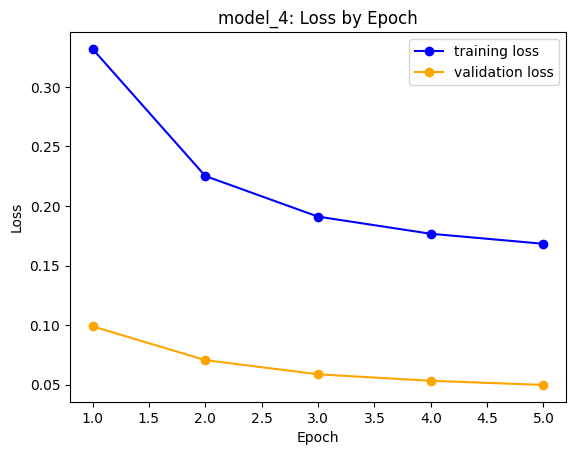

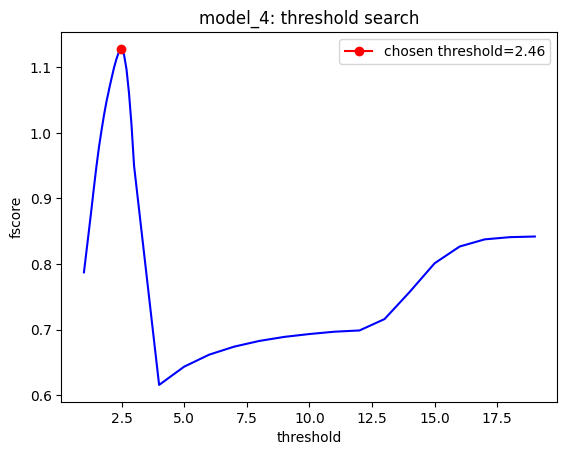

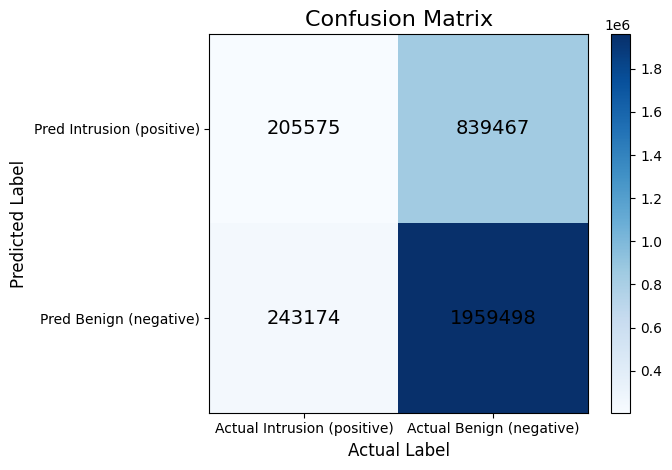

tpr: 0.45810687043313747, fpr: 0.29992050633001843, tnr: 0.5418931295668625, fnr: 0.5418931295668625


In [41]:
# analyze

with open("models/models.json", "r") as file:
    saved_models = json.load(file)
model_name = f'model_{len(saved_models)}'
color_list = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']

historical_pred = torch.cat(historical_pred_tensor).tolist()
historical_label = torch.cat(historical_label_tensor).tolist()

# epoch loss
loss_plt, ax = plt.subplots()
ax.plot(range(1, len(historical_loss) + 1), historical_loss, marker='o', color='blue', label="training loss")
ax.plot(range(1, len(historical_val_loss) + 1), historical_val_loss, marker='o', color='orange', label="validation loss")
ax.set_title(f'{model_name}: Loss by Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show(loss_plt.number)

# threshold search
threshold_plt, ax = plt.subplots()
thresh_sort, fscore_sort = zip(*sorted(zip(historical_threshold, historical_fscore)))
ax.plot(thresh_sort, fscore_sort, color='blue')
ax.plot(best_threshold, best_fscore_sum, color='red', marker='o', label=f'chosen threshold={best_threshold}')
ax.set_title(f'{model_name}: threshold search')
ax.set_xlabel('threshold')
ax.set_ylabel('fscore')
ax.legend()
plt.show(threshold_plt.number)

# confusion matrix
tp = 0
fp = 0
fn = 0
tn = 0
for i in range(len(historical_label)):
    if historical_label[i]:
        if historical_pred[i]:
            tp += 1
        else:
            fn += 1
    else:
        if historical_pred[i]:
            fp += 1
        else:
            tn += 1
tpr = tp / (tp + fn)
fpr = fp / (tn + fp)
tnr = tn / (tn + fp)
fnr = fn / (tp + fn)

conf_matrix = np.array([[tp, fp],[fn, tn]])
classes = ['Intrusion (positive)','Benign (negative)']
conf_plt, ax = plt.subplots()
im = ax.imshow(conf_matrix, cmap='Blues')
for i in range(2):
    for j in range(2):
        ax.text(j, i, conf_matrix[i, j], ha='center', va='center', color='black', fontsize=14)
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(['Actual ' + c for c in classes])
ax.set_yticklabels(['Pred ' + c for c in classes])
ax.set_title('Confusion Matrix', fontsize=16)
ax.set_xlabel('Actual Label', fontsize=12)
ax.set_ylabel('Predicted Label', fontsize=12)
conf_plt.tight_layout()
conf_plt.colorbar(im)
plt.show(conf_plt.number)
print(f"tpr: {tpr}, fpr: {fpr}, tnr: {fnr}, fnr: {fnr}")

# chart, name
charts = [(loss_plt, f"charts/{model_name}-loss.jpg"), 
          (conf_plt, f"charts/{model_name}-conf.jpg"),
          (threshold_plt, f"charts/{model_name}-threshold.jpg"),
         ]

In [42]:
# review
save_path = f"models/{model_name}.pth"
model_object = {
    "path": save_path,
    "lr": float(lr),
    "beta1": float(beta1),
    "beta2": float(beta2),
    "weight_decay": float(weight_decay),
    "epochs": int(epochs),
    "loss_fn": str(loss_fn.__str__()),
    "train_loss": float(train_loss),
    "val_loss": float(epoch_val_loss),
    "test_loss": float(test_loss),
    "desc": str(model_desc),
    "acc": float(test_loss),
    "thresh": float(best_threshold),
    "percision": list(test_percision),
    "recall": list(test_recall),
    "fscore": list(test_fscore),
    "tpr": float(tpr),
    "fpr": float(fpr),
    "tnr": float(tnr),
    "fnr": float(fnr),
    "charts": [name for _, name in charts],
}
json_str = json.dumps(model_object, indent=4)

print(json_str)

{
    "path": "models/model_4.pth",
    "lr": 1e-05,
    "beta1": 0.9,
    "beta2": 0.999,
    "weight_decay": 0.001,
    "epochs": 20,
    "loss_fn": "MSELoss()",
    "train_loss": 0.16827212759678334,
    "val_loss": 0.0,
    "test_loss": 0.6666452156809374,
    "desc": "DNN(\n  (input): Linear(in_features=136, out_features=68, bias=True)\n  (output): Linear(in_features=68, out_features=136, bias=True)\n  (dropout): Dropout(p=0.6, inplace=False)\n  (hiddens): ModuleList()\n)",
    "acc": 0.6666452156809374,
    "thresh": 2.46,
    "percision": [
        0.9838770579201189,
        0.37261580136414657
    ],
    "recall": [
        0.4189090242693578,
        0.980497167225964
    ],
    "fscore": [
        0.5876234210864562,
        0.5400121736795663
    ],
    "tpr": 0.45810687043313747,
    "fpr": 0.29992050633001843,
    "tnr": 0.7000794936699816,
    "fnr": 0.5418931295668625,
    "charts": [
        "charts/model_4-loss.jpg",
        "charts/model_4-conf.jpg",
        "charts/

In [43]:
# save
save = input("save (y/n): ")
if save == "y":
    torch.save(model.state_dict(), save_path)
    notes = input("notes: ")
    model_object['notes'] = notes

    for chart, name in charts:
        chart.savefig(name)

    with open("models/models.json", "r") as file:
        saved_models = json.load(file)
        saved_models.append(model_object)
    with open("models/models.json", "w") as file:
        json.dump(saved_models, file, indent=4)